# Setup

In [1]:
import pandas as pd
import tensorflow as tf
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from xgboost import plot_importance
import random
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical
plt.rcParams["figure.figsize"] = (20,10)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
base_path = '/content/drive/My Drive/ML/'
train_features_file = base_path + 'train_set_values.csv'
train_labels_file = base_path + 'train_set_labels.csv'
test_features_file = base_path + 'test_set_values.csv'

In [4]:
train_df = pd.read_csv(train_features_file)
labels_df = pd.read_csv(train_labels_file)
test_df = pd.read_csv(test_features_file)
train_size, test_size = train_df.shape[0], test_df.shape[0]
labels = labels_df['status_group']
ids = pd.DataFrame(test_df['id'])
datasets=[train_df,test_df]

# Data visualization

In [5]:
train_df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [7]:
train_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [ ]:
train_df.subvillage.value_counts()

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64

In [ ]:
train_df.lga.value_counts()[:10]

Njombe          2503
Arusha Rural    1252
Moshi Rural     1251
Bariadi         1177
Rungwe          1106
Kilosa          1094
Kasulu          1047
Mbozi           1034
Meru            1009
Bagamoyo         997
Name: lga, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


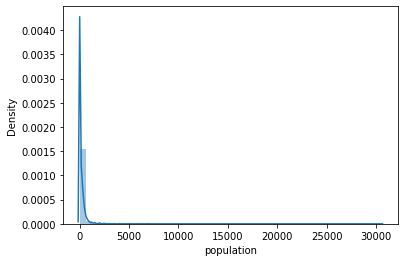

In [10]:
sns.distplot(train_df['population'])

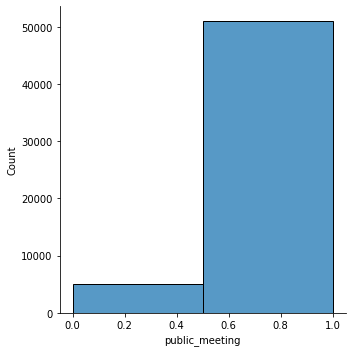

In [11]:
sns.displot(train_df, x=train_df['public_meeting'], bins=2)

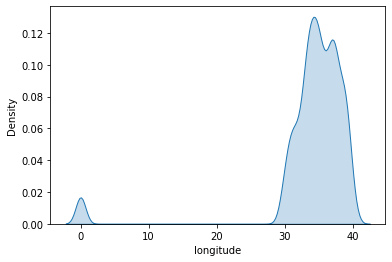

In [12]:
sns.kdeplot(data=train_df['longitude'], shade=True)

# Pre Processing

In [ ]:
# data=data.dropna()

In [ ]:
for i in range(len(datasets)):
  datasets[i] = datasets[i].drop(['id','subvillage','extraction_type_group',
                                  'extraction_type_class','lga','ward','wpt_name','num_private','region','recorded_by',
                                  'scheme_name','payment','quality_group','quantity_group','source_type',
                                  'source_class','waterpoint_type_group'],axis=1) 
  
  # datasets[i] = datasets[i].drop(['id','funder','installer','subvillage','extraction_type','management',
  #                               'extraction_type_class','lga','ward','wpt_name','num_private','region','recorded_by',
  #                               'scheme_name','payment','water_quality','quantity','source',
  #                               'source_class','waterpoint_type'],axis=1) 

  datasets[i]['public_meeting'] = datasets[i]['public_meeting'].fillna(True)
  datasets[i]['permit'] = datasets[i]['permit'].fillna(True)
  datasets[i]['scheme_management'] = datasets[i]['scheme_management'].fillna('other')
  datasets[i]['installer'] = datasets[i]['installer'].fillna('other')

  gpu_labels=datasets[i].groupby(pd.cut(datasets[i]['gps_height'],[0, 250, 500, 750, 1000,1250,1500,1750,2000,2250,2500])).gps_height.median()
  gpu_labels[0]=0
  datasets[i]['gps_height'] = pd.cut(datasets[i]['gps_height'], bins=10, labels=gpu_labels)
  datasets[i]['date_recorded'] = pd.to_datetime(datasets[i]['date_recorded'], format="%Y-%m-%d")
  datasets[i]['date_recorded'] = datasets[i]['date_recorded'].dt.year

  threshold = train_df.funder.value_counts()
  threshold_values = threshold[:5].index
  datasets[i]['funder'] = datasets[i].funder.where(datasets[i].funder.isin(threshold_values), 'Other') 

  threshold = train_df.scheme_management.value_counts()
  threshold_values = threshold[:5].index
  datasets[i]['scheme_management'] = datasets[i].scheme_management.where(datasets[i].scheme_management.isin(threshold_values), 'Other') 

  threshold = train_df.management.value_counts()
  threshold_values = threshold[:5].index
  datasets[i]['management'] = datasets[i].management.where(datasets[i].management.isin(threshold_values), 'Other') 

  threshold = train_df.installer.value_counts()
  threshold_values = threshold[:4].index
  datasets[i]['installer'] = datasets[i].installer.where(datasets[i].installer.isin(threshold_values), 'Other') 

  datasets[i]['amount_tsh'] = scaler.fit_transform(datasets[i]['amount_tsh'].values.reshape(-1,1))
  datasets[i]['population'] = scaler.fit_transform(datasets[i]['population'].values.reshape(-1,1))  

  datasets[i].loc[datasets[i]['extraction_type'] == 'india mark iii', 'extraction_type'] = 'india mark ii'
  datasets[i].loc[datasets[i]['extraction_type'] == 'other - rope pump', 'extraction_type'] = 'other'
  datasets[i].loc[datasets[i]['extraction_type'] == 'other - swn 81', 'extraction_type'] = 'swn 80'

  # datasets[i].loc[datasets[i]['permit'] == False, 'permit'] = 0
  # datasets[i].loc[datasets[i]['permit'] == True, 'permit'] = 1

In [ ]:
datasets=pd.concat([datasets[0], datasets[1]])
nominal_cols = ['basin', 'funder','scheme_management','installer', 'extraction_type', 'payment_type','management', 'management_group', 'water_quality','quantity','source','waterpoint_type']

# nominal_cols = ['basin', 'scheme_management', 'extraction_type_group', 'payment_type', 'management_group', 'quality_group','quantity_group','source_type','waterpoint_type_group']

for ncol in nominal_cols:
  one_hot = pd.get_dummies(datasets[ncol],prefix=ncol)
  datasets = datasets.drop(ncol, axis = 1)
  datasets = pd.concat([datasets, one_hot], axis=1)
train_df, test_df = datasets.iloc[:train_size,:], datasets.iloc[train_size:,:]

In [ ]:
train_df.describe()

,amount_tsh,date_recorded,gps_height,longitude,latitude,region_code,district_code,population,construction_year,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,scheme_management_Other,scheme_management_VWC,scheme_management_WUG,scheme_management_Water authority,extraction_type_group_afridev,extraction_type_group_gravity,extraction_type_group_india mark ii,extraction_type_group_india mark iii,extraction_type_group_mono,extraction_type_group_nira/tanira,extraction_type_group_other,extraction_type_group_other handpump,extraction_type_group_other motorpump,extraction_type_group_rope pump,extraction_type_group_submersible,extraction_type_group_swn 80,extraction_type_group_wind-powered,payment_type_annually,payment_type_monthly,payment_type_never pay,payment_type_on failure,payment_type_other,payment_type_per bucket,payment_type_unknown,management_group_commercial,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group,quality_group_colored,quality_group_fluoride,quality_group_good,quality_group_milky,quality_group_salty,quality_group_unknown,quantity_group_dry,quantity_group_enough,quantity_group_insufficient,quantity_group_seasonal,quantity_group_unknown,source_type_borehole,source_type_dam,source_type_other,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,0.000908,2011.921667,622.590943,34.077427,-5.706033e+00,15.297003,5.629747,0.005899,1300.652475,0.131061,0.085606,0.041313,0.108283,0.172525,0.150505,0.134276,0.075640,0.100791,0.239865,0.619411,0.087643,0.053081,0.029798,0.450842,0.040404,0.001650,0.048232,0.137273,0.108249,0.006128,0.002054,0.007593,0.104024,0.061785,0.001970,0.061313,0.139731,0.426734,0.065892,0.017744,0.151263,0.137323,0.061246,0.015875,0.029764,0.009444,0.883670,0.008249,0.003653,0.855522,0.013535,0.087458,0.031582,0.105152,0.558687,0.254697,0.068182,0.013283,0.201162,0.011044,0.004680,0.038636,0.174697,0.283232,0.286549,0.001953,0.582912,0.000118,0.294411,0.013199,0.107407
std,0.008564,0.958758,639.990520,6.567432,2.946019e+00,17.587406,9.633649,0.015458,951.620547,0.337469,0.279784,0.199015,0.310740,0.377840,0.357569,0.340952,0.264423,0.301055,0.427005,0.485536,0.282778,0.224197,0.170031,0.497582,0.196907,0.040585,0.214259,0.344138,0.310697,0.078042,0.045273,0.086805,0.305294,0.240766,0.044338,0.239906,0.346710,0.494607,0.248096,0.132021,0.358308,0.344191,0.239783,0.124995,0.169938,0.096723,0.320623,0.090450,0.060332,0.351577,0.115552,0.282507,0.174887,0.306751,0.496548,0.435694,0.252060,0.114484,0.400872,0.104508,0.068252,0.192728,0.379711,0.450572,0.452153,0.044148,0.493082,0.010855,0.455781,0.114126,0.309633
min,0.000000,2002.000000,0.000000,0.000000,-1.164944e+01,1.000000,0.00

In [ ]:
train_df.to_csv(base_path + 'preprocessed_train.csv',index=False)
test_df['id'] = ids['id']
test_df.to_csv(base_path +'preprocessed_test.csv',index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# XGBoost

In [ ]:
rnd = random.randint(1, 32000) 

In [ ]:
X_train, X_eval, y_train, y_eval = train_test_split(train_df,labels,test_size=0.2,shuffle=True)

In [ ]:
xg = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bytree=0.4, gamma=0.0,
             importance_type='gain', learning_rate=0.05,max_depth=3, min_child_weight=7, 
             n_estimators=100,n_jobs=1,num_class=3, objective='multi:softmax',
             random_state=0, reg_lambda=1, scale_pos_weight=1,subsample=1, verbosity=1)
xg.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.0,
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=7, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, num_class=3, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

# Feature Importance

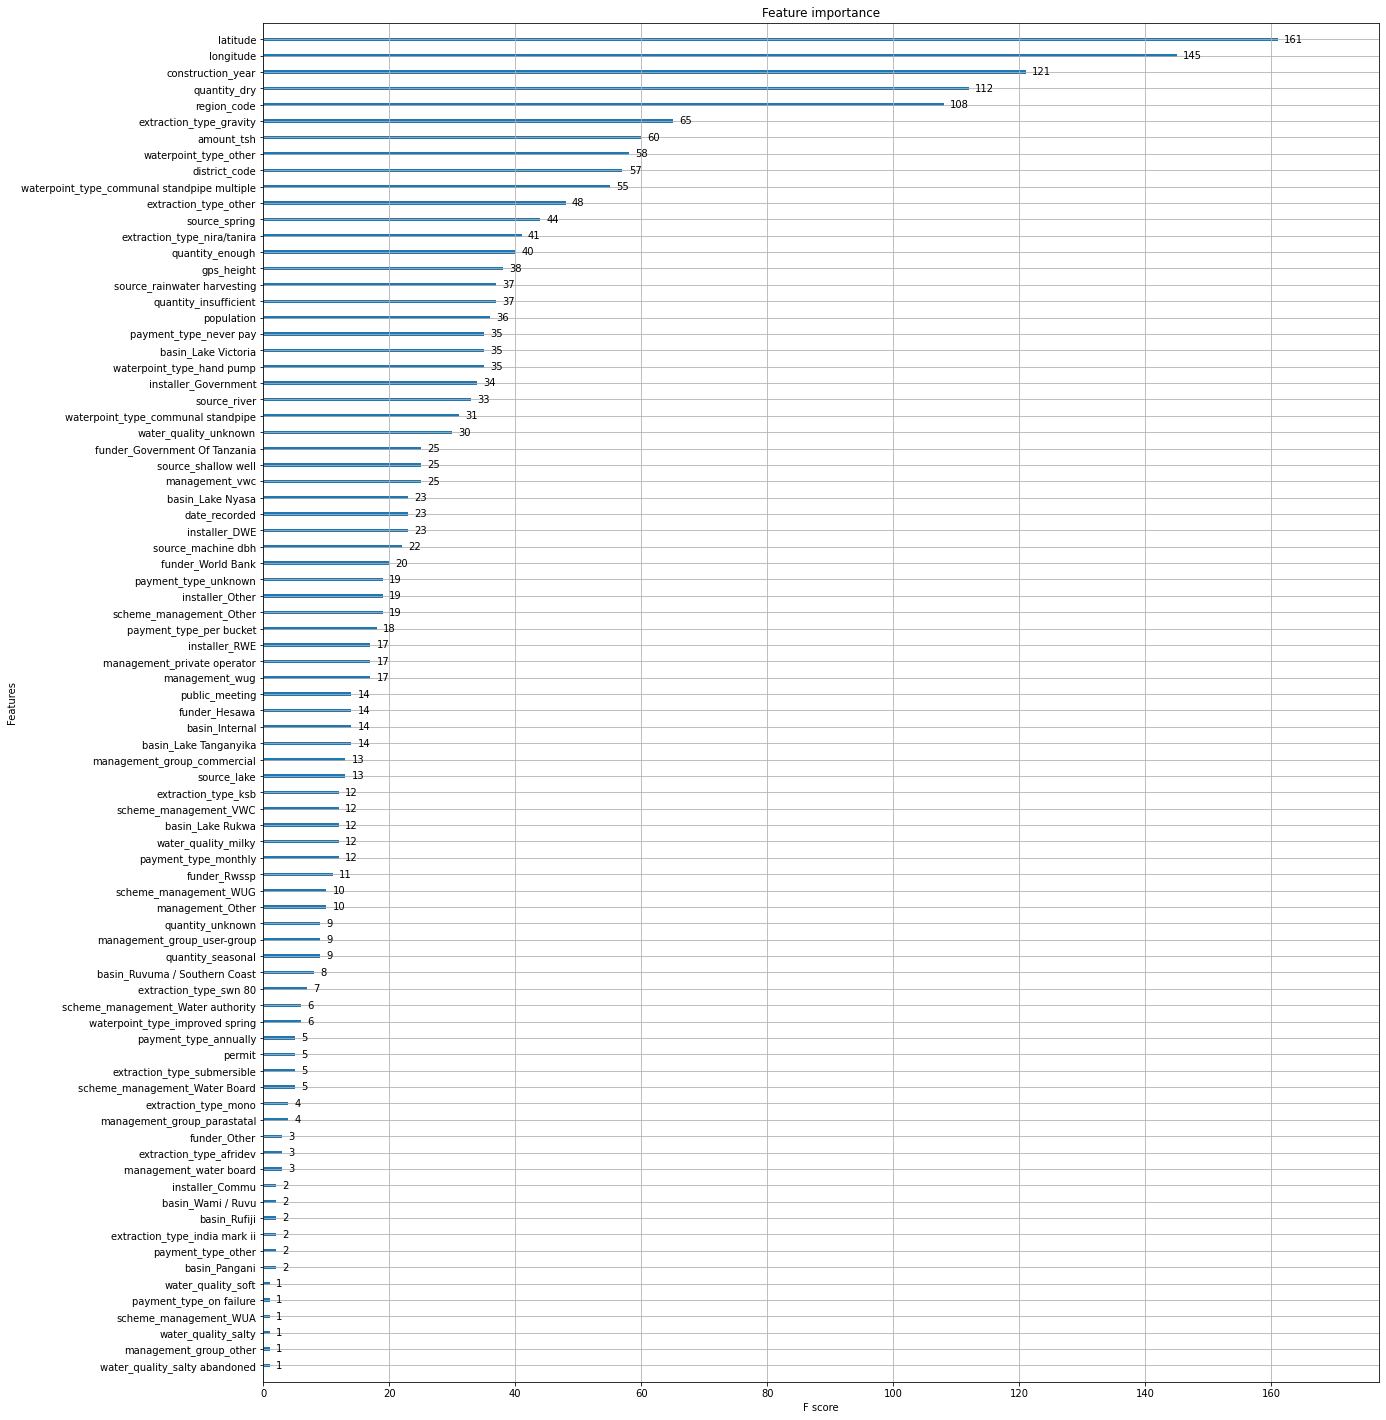

In [ ]:
ax = plot_importance(xg)
fig = ax.figure
fig.set_size_inches(20, 25)
fig.show()

In [ ]:
train_df

,amount_tsh,date_recorded,gps_height,longitude,latitude,region_code,district_code,population,public_meeting,permit,construction_year,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,scheme_management_Other,scheme_management_VWC,scheme_management_WUG,scheme_management_Water authority,extraction_type_afridev,extraction_type_cemo,extraction_type_climax,extraction_type_gravity,extraction_type_india mark ii,extraction_type_ksb,extraction_type_mono,extraction_type_nira/tanira,extraction_type_other,extraction_type_other - mkulima/shinyanga,extraction_type_other - play pump,extraction_type_submersible,extraction_type_swn 80,extraction_type_walimi,extraction_type_windmill,payment_type_annually,...,payment_type_unknown,management_Other,management_vwc,management_water board,management_wug,management_group_commercial,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group,water_quality_coloured,water_quality_fluoride,water_quality_fluoride abandoned,water_quality_milky,water_quality_salty,water_quality_salty abandoned,water_quality_soft,water_quality_unknown,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,source_dam,source_hand dtw,source_lake,source_machine dbh,source_other,source_rainwater harvesting,source_river,source_shallow well,source_spring,source_unknown,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
0,0.017143,2011,1362.0,34.938093,-9.856322,11,5,0.003574,True,False,1999,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,0.000000,2013,1362.0,34.698766,-2.147466,20,2,0.009180,True,True,2010,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
2,0.000071,2013,635.0,37.460664,-3.821329,21,4,0.008197,True,True,2009,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0.000000,2013,340.0,38.486161,-11.155298,90,63,0.001902,True,True,1986,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0.000000,2011,0.0,31.130847,-1.825359,18,1,0.000000,True,True,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,0.000029,2013,1152.0,37.169807,-3.253847,3,5,0.004098,True,True,1999,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
59396,0.013429,2011,1152.0,35.249991,-9.070629,11,4,0.001836,True,True,1996,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
59397,0.000000,2011,0.0,34.017087,-8.750434,12,7,0.000000,True,False,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
59398,0.000000,2011,0.0,35.861315,-6.378573,1,4,0.000000,True,True,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0


In [ ]:
preds = xg.predict(X_eval)

In [ ]:
f1_score(y_eval, preds, average=None)

array([0.79799296, 0.09803922, 0.66942369])

# Hyperparameter Tuning

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

In [ ]:
params={
  "n_estimators"     : [ 100, 500, 1000],
  "learning_rate"    : [ 0.05, 0.10, 0.30 ] ,
  "max_depth"        : [ 3, 10, 15],
  "min_child_weight" : [ 1, 5, 7 ],
  "gamma"            : [ 0.0, 0.3, 0.4 ],
  "colsample_bytree" : [ 0.3, 0.5 , 0.7 ]
}



In [ ]:
from sklearn.ensemble import RandomForestClassifier


X_train, X_test, y_train_h1n1, y_test_h1n1 = train_test_split(train_df, labels, test_size=0.2, random_state=123)
model = RandomForestClassifier(n_estimators=10, max_depth=None,min_samples_split=2, random_state=0)
grid = GridSearchCV(estimator=xg_test, param_grid=params, n_jobs=-1, cv=3, verbose = 10 )
grid_result = grid.fit(train_df, labels)

In [ ]:
X_train, X_test, y_train_h1n1, y_test_h1n1 = train_test_split(train_df, labels, test_size=0.2, random_state=123)

xg_test = xgb.XGBClassifier(objective ='multi:softmax',num_class=3)
grid = GridSearchCV(estimator=xg_test, param_grid=params, n_jobs=-1, cv=3, verbose = 10 )
grid_result = grid.fit(train_df, labels)

Fitting 3 folds for each of 729 candidates, totalling 2187 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 23.9min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 45.8min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 66.8min


# SHAP and PDP

In [ ]:
# from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
# import matplotlib.pyplot as plt

# from sklearn.inspection import partial_dependence, plot_partial_dependence
# plot_partial_dependence(model, X, features)

# plot_partial_dependence(xg, features=[0, 2],X=labels,feature_names=['amount_tsh', 'date_recorded', 'gps_height'])

In [ ]:
# !pip install shap

In [ ]:
# import shap
# make sure the SHAP values add up to marginal predictions
# pred = model.predict(Xd, output_margin=True)
# explainer = shap.TreeExplainer(xg_reg)
# shap_values = explainer.shap_values(X_eval)
# np.abs(shap_values.sum(1) + explainer.expected_value - pred).max()

In [ ]:
# shap.summary_plot(shap_values, y_eval)
